In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
import math  
from scipy.fft import fft, fftfreq, ifft


In [2]:

# Compute RMS value of the signal
#Function that Calculate Root Mean Square  
def rmsValue(arr, n): 
    square = 0
    mean = 0.0
    root = 0.0
      
    #Calculate square 
    for i in range(0,n): 
        square += (arr[i]**2) 
      
    #Calculate Mean  
    mean = (square / (float)(n)) 
      
    #Calculate Root 
    root = math.sqrt(mean) 
      
    return root 
    
def fft_to_db(x):
    if x > 0:
        fft = 20 * math.log10(x/prms)
        if fft < 0:
            fft = 0
    else: 
        fft = 0
    return fft

In [3]:
%%time
data = pd.read_excel("anechoic_3400rpm.xlsx")

# find negative start point
val = data.crank_angle[0]

print("First value ", val)

# Shift the first angle to 0 degrees to then convert to time
if val < 0:
    data.crank_angle = data.crank_angle.apply(lambda x: x - val)

# Number of times to multiply the data to find the frequencies. 
n = 20
crank_angle = data.crank_angle
pressure = data.total_pressure
final_val = data.crank_angle[len(data)-1]

for i in range(1,n+1):
    new_ca = crank_angle+i*final_val
    new_data = pd.DataFrame([new_ca, pressure]).T
    data = data.append(new_data)

rpm = 3200
rps = rpm/60
seconds_per_rev = 1/rps
data["time"] = data.crank_angle.apply(lambda x: (x/360)*seconds_per_rev)
data.head()
len(data)

First value  -94.0
Wall time: 2.11 s


15225

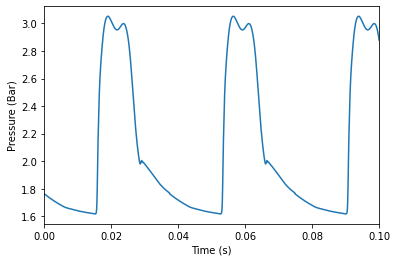

In [4]:
plt.plot(data.time, data.total_pressure)
plt.xlabel("Time (s)")
plt.ylabel("Pressure (Bar)")
plt.xlim([0, 0.1])
plt.savefig("pressure_wave_input.png")
plt.show()

In [5]:
pressure = data.total_pressure
pressure_array = np.array(pressure)
time = data.time
pressure_array = pressure.values.tolist()

prms = rmsValue(np.array(data.total_pressure), len(data))

print(f"final time value {time.iloc[-1]}")

final time value 0.7864062500000001


Sampling frequency is 800.0Hz. Must be greater than 2x the largest expected frequency.
Total sampling time 0.7875s
Frequency resolution is 1.2698412698412698Hz


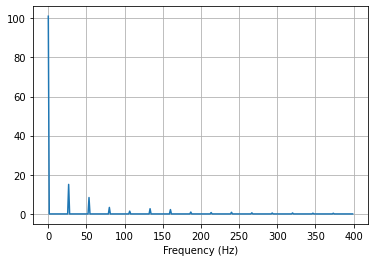

In [6]:
# Number of sample points
N = 630

# sample spacing
T = 1.0 / 800
sampling_rate = 1 / T

# Sampling frequency is 1/T
print(f"Sampling frequency is {sampling_rate}Hz. Must be greater than 2x the largest expected frequency.")

print(f"Total sampling time {N*T}s")

# Frequency resolution
print(f"Frequency resolution is {sampling_rate/N}Hz")

y = pressure_array

yf = fft(y)
xf = fftfreq(N, T)[:N//2]
plt.xlabel("Frequency (Hz)")
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.savefig("anechoic_3200rpm_freq_breakdown.png")
plt.show()
#print(xf)



In [7]:
fft_df = pd.DataFrame({"fft_raw": np.abs(yf)[0:N//2], "freq": xf})
fft_df["fft_db"] = fft_df.fft_raw.map(lambda x: fft_to_db(x))
fft_df.head()



,fft_raw,freq,fft_db
0,3.182229e+04,0.000000,83.381945
1,1.133422e-13,1.269841,0.000000
2,1.613616e-13,2.539683,0.000000
3,9.531862e-14,3.809524,0.000000
4,1.113678e-13,5.079365,0.000000


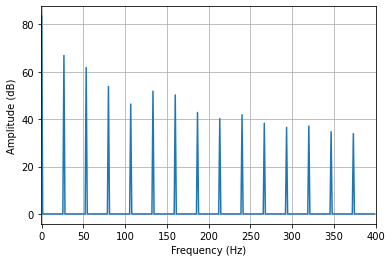

In [8]:
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.plot(xf, fft_df.fft_db[0:N//2])
plt.grid()
plt.xlim([-1, 400])
plt.savefig("anechoic_3200rpm_freq_breakdown_dB.png")
plt.show()

In [9]:
#Create the sample points
final_time = time.iloc[-1]
t = np.linspace(0, final_time, 5000)

fft_filtered = fft_df[fft_df.fft_db > 0][0:14]
fft_filtered.head()



,fft_raw,freq,fft_db
0,31822.287090,0.000000,83.381945
21,4750.959911,26.666667,66.862944
42,2637.278819,53.333333,61.750438
63,1046.399719,80.000000,53.721269
84,447.354683,106.666667,46.340357


In [11]:
# Turn the frequencies back into sinusoids
x = np.linspace(0,0.1,2000)
y = np.ones(len(x))*fft_filtered.fft_raw.iloc[0]
for i in range(1, len(fft_filtered)):
    row = fft_filtered.iloc[i]
    amp = row.fft_raw
    fre = row.freq
    func = amp * np.sin(2*np.pi*fre * x)
    y = y + func
    print(y[0:3])

[31822.2870903  31862.10808344 31901.926279  ]
[31822.2870903  31906.31614865 31990.32998652]
[31822.2870903  31932.62542532 32042.93190574]
[31822.2870903  31947.62111417 32072.90642888]
[31822.2870903  31982.76178282 32143.12605582]
[31822.2870903  32017.79950348 32213.11290027]
[31822.2870903  32035.23369675 32247.92128767]
[31822.2870903  32050.04713076 32277.48157556]
[31822.2870903  32070.09570874 32317.46469756]
[31822.2870903  32084.86773413 32346.90502955]
[31822.2870903  32098.12935422 32373.31561592]
[31822.2870903  32113.54615348 32403.99338046]
[31822.2870903  32126.23835117 32429.22723117]


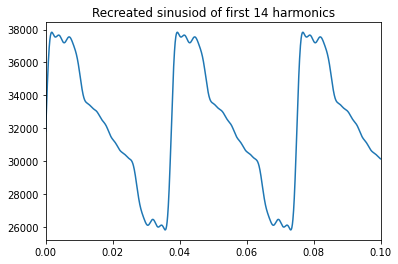

In [12]:
plt.plot(x,y)
plt.title(f"Recreated sinusiod of first {len(fft_filtered)} harmonics")
plt.xlim([0, 0.1])
plt.savefig(f"recreated_pressure_wave_{len(fft_filtered)}_harmonics.png")
plt.show()

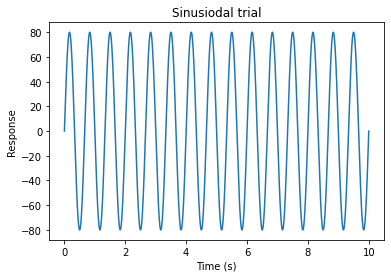

In [269]:
x_tr = np.linspace(0,10,2000)
y_tr = 80*np.sin(np.pi*3*x_tr)

plt.plot(x_tr,y_tr)
plt.title("Sinusiodal trial")
plt.xlabel("Time (s)")
plt.ylabel("Response")
plt.show()

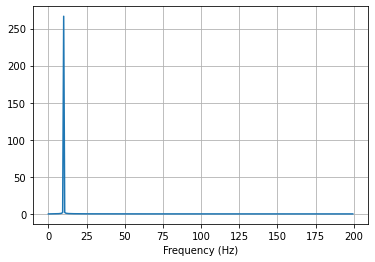

In [270]:
N = 600
sf = 400
T = 1 / sf


yf = fft(y_tr)
xf = fftfreq(N, T)[:N//2]
plt.xlabel("Frequency (Hz)")
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
#plt.savefig("anechoic_3200rpm_freq_breakdown.png")
plt.show()

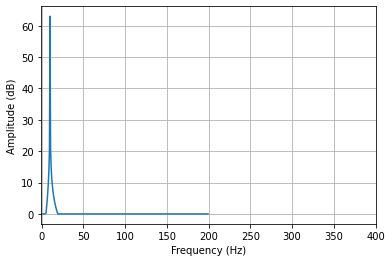

In [271]:
prms = rmsValue(np.array(y_tr), len(y_tr))


fft_df = pd.DataFrame({"fft_raw": np.abs(yf)[0:N//2], "freq": xf})
fft_df["fft_db"] = fft_df.fft_raw.map(lambda x: fft_to_db(x))
fft_df.head()

plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.plot(xf, fft_df.fft_db[0:N//2])
plt.grid()
plt.xlim([-1, 400])
plt.show()

In [272]:
fft_filtered = fft_df[fft_df.fft_db > 0][0:9]
fft_filtered.head()

,fft_raw,freq,fft_db
8,59.564372,5.333333,0.450404
9,74.908985,6.000000,2.441350
10,95.861501,6.666667,4.583557
11,126.695060,7.333333,7.005866
12,177.351283,8.000000,9.927359


In [273]:
y_tr = np.zeros(len(x_tr))
for i in range(1, len(fft_filtered)):
    row = fft_filtered.iloc[i]
    amp = row.fft_raw
    fre = row.freq
    func = amp * np.sin(fre * x_tr)
    y_tr = y_tr + func


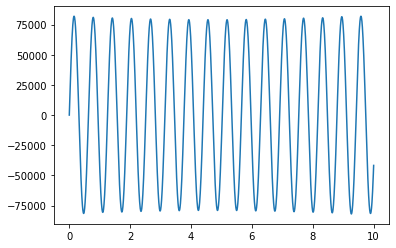

In [274]:
plt.plot(x_tr, y_tr)